# **Problem Statement**
The problem is preety much stright forward, we all are famelier with Garbage and waste material which is very harmful for our society.if we talk about amount of waste then the world almost generates at least 5 million tons of waste per day and this number is still increasing day by day that's why we need to aware about waste. This model which help us to classify waste with 5 different waste materials and it will show you the details of that particular waste materials. This will help to raise awareness for people to reduce and recycle waste.
## **Overview**
- There are <b> 'glass', 'metal','organic','paper', 'plastic'</b> total 5 different types of waste materials which are use for recycling.
- Here I have training 2767 images and testing 794 images belonging 6 classes.
- Here I have trained dataset using pretrained VGG16 model via using Transfer Learning and Fine Tuning technique for classification.
- Here I will train this model till 10 epochs with apply early stoping and we got Test accuracy: 0.7461 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Train Datasets Collection & Understanding**

In [3]:
train_path = '/content/drive/MyDrive/Multiclassification_1/train'

Class to label mapping: {'glass': 0, 'metal': 1, 'organic': 2, 'paper': 3, 'plastic': 4}


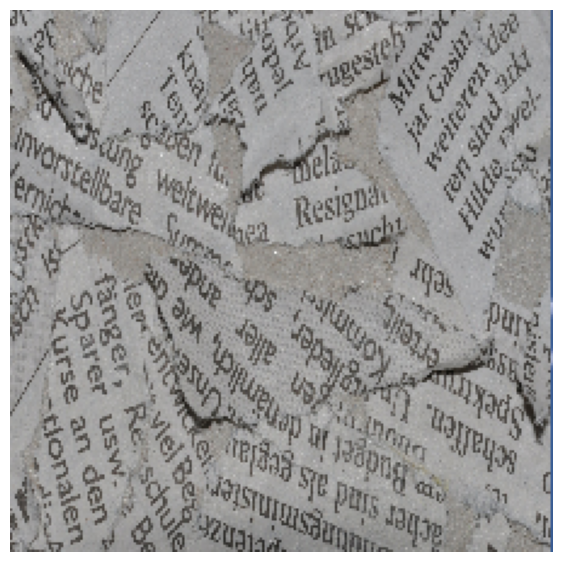

(2775, 224, 224, 3) (2775,)


In [4]:
class_names = os.listdir(train_path)
# Create a dictionary for mapping class names to integer labels
# Sorting ensures a consistent mapping
class_to_label_dict = {name: i for i, name in enumerate(sorted(class_names))}
print(f"Class to label mapping: {class_to_label_dict}")

train_data = []
train_labels = []
for class_name in class_names:
  dir_path = os.path.join(train_path, class_name)
  for image_name in os.listdir(dir_path):
    img_path = os.path.join(dir_path, image_name)
    # Read as 3-channel image. If grayscale, cv2.imread will convert it.
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        continue
    img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
    train_data.append(img)
    train_labels.append(class_to_label_dict[class_name])

plt.figure(figsize=(7,10))
plt.axis('off')
# Ensure img is not None before plotting and convert BGR to RGB for matplotlib
if 'img' in locals() and img is not None:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
else:
    print("No image to display (possibly due to read errors).")
plt.show() # Explicitly show the plot
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)


In [ ]:
# Convert the actual training data from BGR to RGB
train_data = train_data[..., ::-1]

# Now train_data is RGB and ready for VGG16 preprocessing

In [ ]:
train_data.shape

## Training Datas Labels

In [5]:
# Show the data classes
classes = os.listdir(train_path)
classes

['glass', 'metal', 'organic', 'plastic', 'paper']

### **Test Datasets Collection & Understanding**

In [6]:
test_path = '/content/drive/MyDrive/Multiclassification_1/test'

In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Ensure you defined test_path somewhere, e.g.: test_path = 'path/to/test'

test_data = []
test_labels = []

print("Loading Test Data...")
for class_name in class_names: # Use same class_names list as training
    dir_path = os.path.join(test_path, class_name)
    if not os.path.exists(dir_path): continue # Skip if folder missing

    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        img = cv2.imread(img_path)
        if img is None: continue

        # 1. Resize
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)

        # 2. Convert BGR to RGB immediately
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        test_data.append(img)
        test_labels.append(class_to_label_dict[class_name])

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(f"Test Data Shape: {test_data.shape}")


Loading Test Data...
Test Data Shape: (794, 224, 224, 3)


### **Data Augmentation part done on training Dataset**

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. Training Generator (With Augmentation)
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Load Training Data
training_data = training_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 3. Validation Generator (NO Augmentation)
# We need a separate generator for validation/testing that only preprocesses.
# We do not want to flip or rotate our validation images.


Found 2767 images belonging to 5 classes.


In [9]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### **Data Augmentation Visualization**

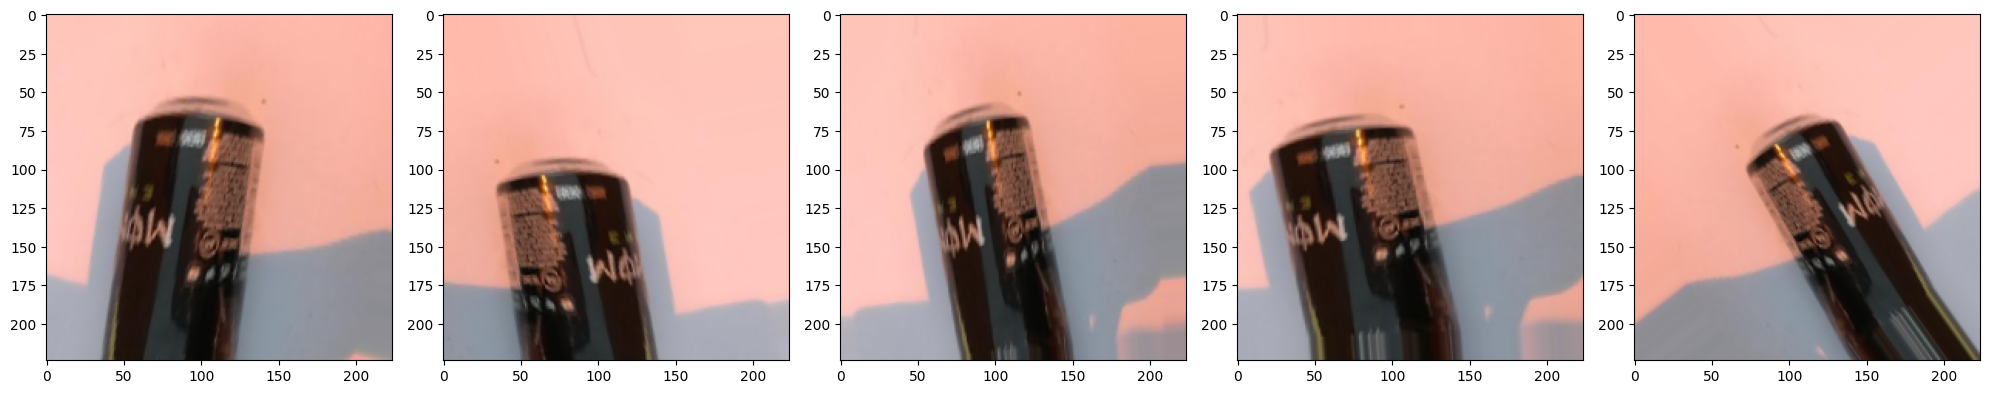

In [10]:
# showing augmented images
images = [training_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

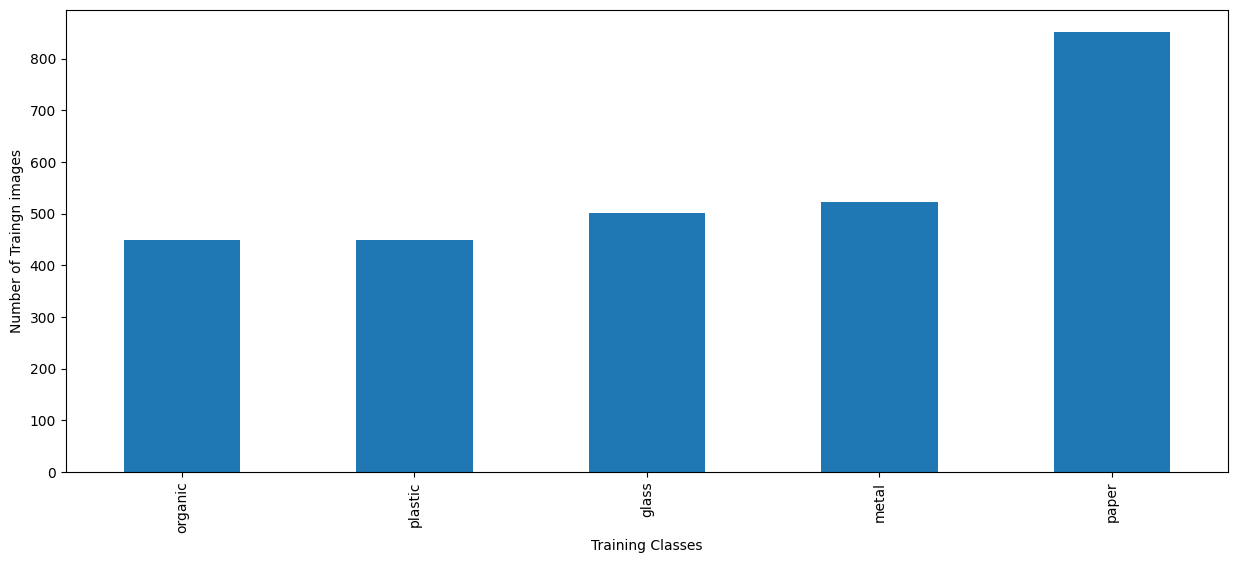

In [11]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(train_path):
    data_dic[folder] = len(os.listdir(train_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

### **Data Augmentation part done on Testing Dataset**

In [12]:
testing_datagen = ImageDataGenerator(rescale=1./255)

testing_data = testing_datagen.flow_from_directory(
    test_path, # Point this to your test/validation folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Important for evaluating later
)

Found 788 images belonging to 5 classes.


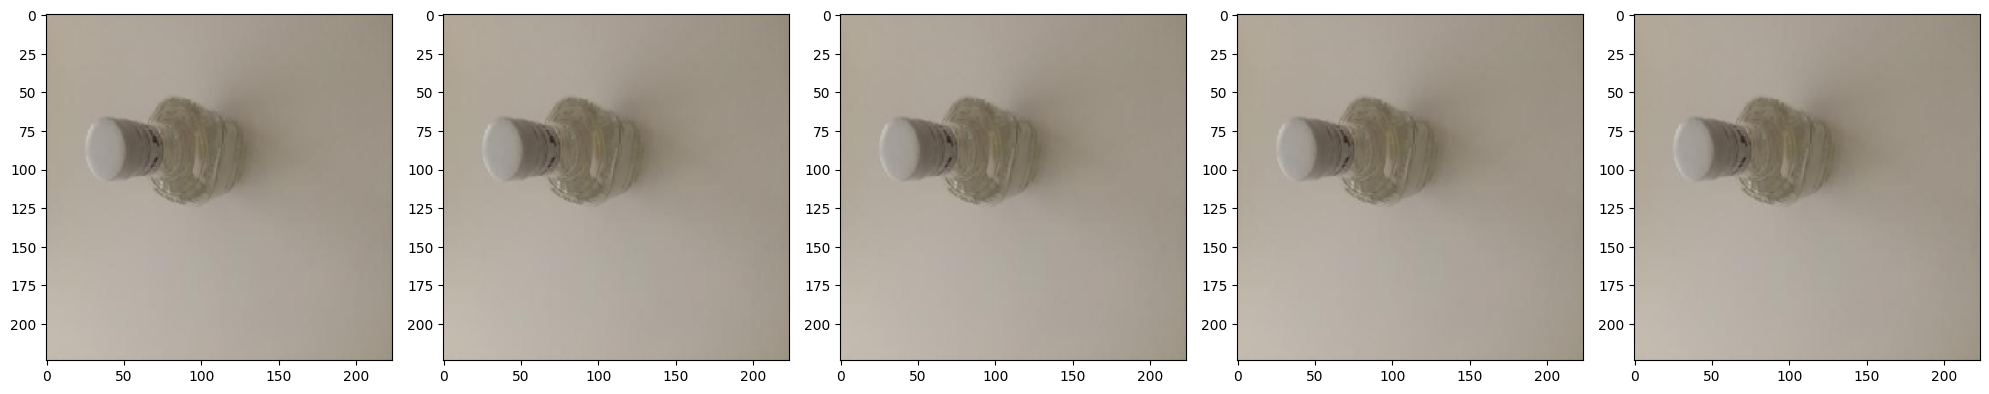

In [13]:
# showing augmented images
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Validation images')

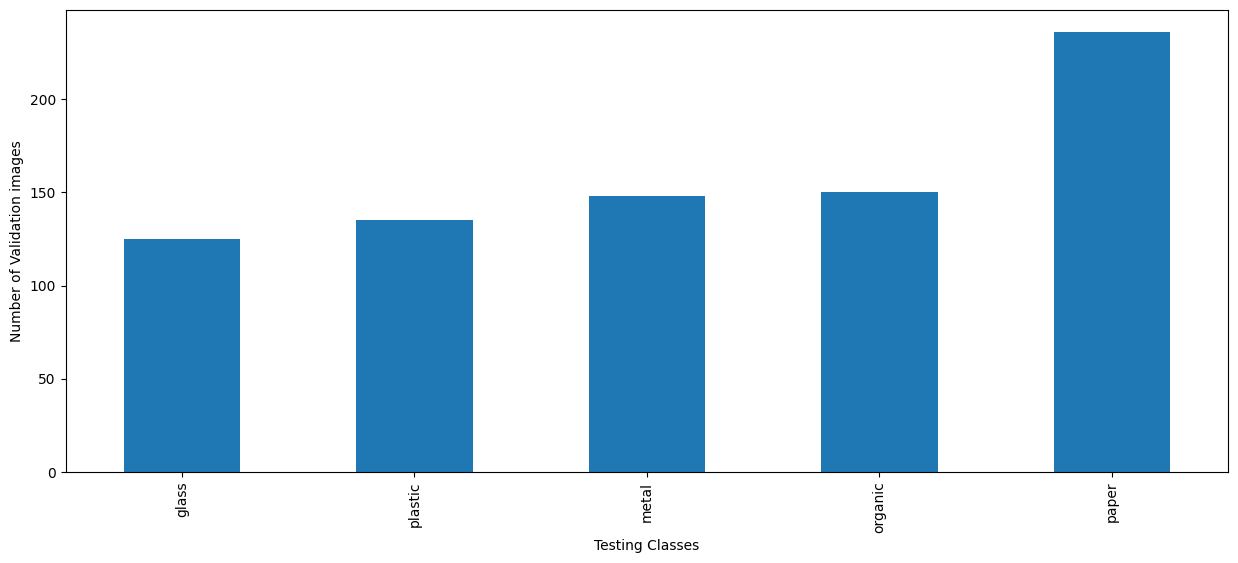

In [14]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(test_path):
    data_dic[folder] = len(os.listdir(test_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Validation images')

## **CNN - VGG16 Architeture using Tranfer Learning**

In [15]:
IMAGE_SIZE = [224, 224]

In [16]:
# We build the base model

# 1. Your code
base_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# 2. CRITICAL STEP: Freeze the weights
for layer in base_model.layers:
    layer.trainable = False

# 3. Check the summary
# You should see "Non-trainable params" count is very high now
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# 1. Take the output from the frozen base model
x = base_model.output

# 2. Add your custom "Head"
x = Flatten()(x)                 # Turn 3D volume into 1D vector
x = Dense(256, activation='relu')(x) # New layer (Trainable!)
x = Dropout(0.5)(x)              # Regularization
prediction = Dense(5, activation='softmax')(x) # Output layer (Trainable!)

# 3. Combine them into the final model
model = Model(inputs=base_model.input, outputs=prediction)

# 4. Compile
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# 5. Check the NEW summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
checkpointer = ModelCheckpoint(
    filepath='vgg16_model.weights.best.keras', # .keras is the modern format
    monitor='val_loss',
    verbose=1, # Set to 1 so you can see when it saves
    save_best_only=True,
    mode='min'
)

# 2. Stop early if the model stops improving (Saves time!)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4, # Wait 4 epochs before giving up
    restore_best_weights=True, # Go back to the best epoch automatically
    mode='min'
)

In [19]:
print("Starting training with Generators...")
result_VGG_TF = model.fit(
    training_data,
    steps_per_epoch=len(training_data),
    epochs=10,
    callbacks=[early_stop, checkpointer],
    validation_data=testing_data,
    validation_steps=len(testing_data)
)

Starting training with Generators...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 9/87 ━━━━━━━━━━━━━━━━━━━━ 44s 568ms/step - accuracy: 0.2035 - loss: 5.5217

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.3723 - loss: 2.8177
Epoch 1: val_loss improved from inf to 1.03948, saving model to vgg16_model.weights.best.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 991ms/step - accuracy: 0.3731 - loss: 2.8062 - val_accuracy: 0.6104 - val_loss: 1.0395
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.5155 - loss: 1.1752
Epoch 2: val_loss improved from 1.03948 to 0.92773, saving model to vgg16_model.weights.best.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 67s 763ms/step - accuracy: 0.5157 - loss: 1.1749 - val_accuracy: 0.6802 - val_loss: 0.9277
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.5627 - loss: 1.0995
Epoch 3: val_loss improved from 0.92773 to 0.84890, saving model to vgg16_model.weights.best.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 786ms/step - accuracy: 0.5629 - loss: 1.0995 - val_accuracy: 0.6789 - val_loss: 0.8489
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.5548 - loss: 1.0584
Epoch 4: val_loss i

In [20]:
probs = model.predict(testing_data,steps = len(testing_data), verbose = 1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step


In [21]:
probs

array([[0.16816933, 0.21573165, 0.13062298, 0.27455968, 0.2109164 ],
       [0.15273839, 0.21052833, 0.30565473, 0.1827409 , 0.14833777],
       [0.16463034, 0.0831978 , 0.32715452, 0.22926441, 0.19575293],
       ...,
       [0.19745652, 0.22887701, 0.20013535, 0.16770755, 0.20582359],
       [0.2936689 , 0.18616232, 0.10580463, 0.08187045, 0.33249372],
       [0.03331328, 0.01933322, 0.78254825, 0.11835428, 0.04645095]],
      dtype=float32)

In [22]:
preds = np.argmax(probs,axis = 1)

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix

# Use the true labels directly from the generator to match the predictions
true_labels_for_evaluation = testing_data.classes

print(classification_report(true_labels_for_evaluation,preds))
print(confusion_matrix(true_labels_for_evaluation,preds))


              precision    recall  f1-score   support

           0       0.60      0.45      0.52       122
           1       0.62      0.78      0.69       147
           2       0.77      0.92      0.84       148
           3       0.84      0.90      0.87       236
           4       0.74      0.44      0.56       135

    accuracy                           0.73       788
   macro avg       0.71      0.70      0.69       788
weighted avg       0.73      0.73      0.72       788

[[ 55  40   6   8  13]
 [ 12 115   7   9   4]
 [  0   5 136   6   1]
 [  0   7  13 213   3]
 [ 24  18  14  19  60]]


In [24]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_data.classes,preds)


cm

array([[ 55,  40,   6,   8,  13],
       [ 12, 115,   7,   9,   4],
       [  0,   5, 136,   6,   1],
       [  0,   7,  13, 213,   3],
       [ 24,  18,  14,  19,  60]])

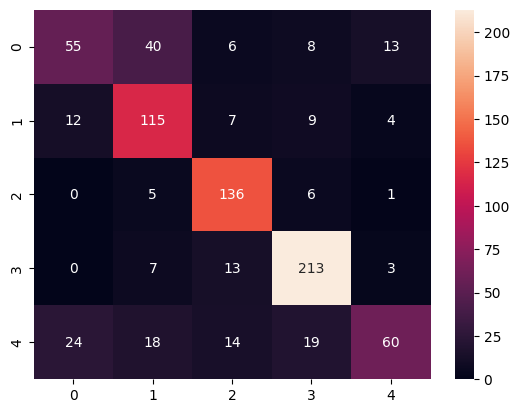

In [25]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.savefig('h1.png')

In [26]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(testing_data, steps = len(testing_data), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

20/25 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 0.6436 - loss: 0.8497

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.6686 - loss: 0.8061
Test loss: 0.7117879390716553
Test accuracy: 0.7347715497016907


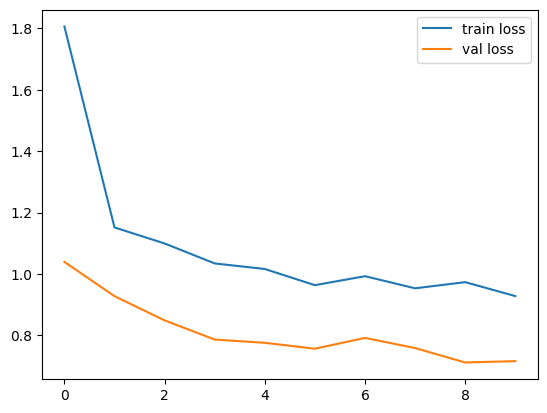

<Figure size 640x480 with 0 Axes>

In [27]:
# loss
plt.plot(result_VGG_TF.history['loss'], label='train loss')
plt.plot(result_VGG_TF.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

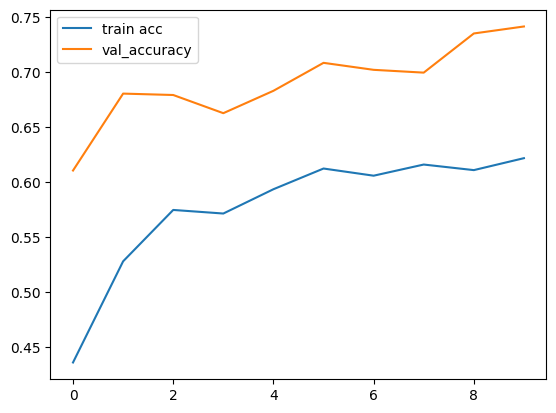

<Figure size 640x480 with 0 Axes>

In [28]:
# accuracies
plt.plot(result_VGG_TF.history['accuracy'], label='train acc')
plt.plot(result_VGG_TF.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [29]:
# Regenerate rev_dict based on the actual class_to_label_dict
# (Assuming class_to_label_dict is defined correctly in an earlier cell and reflects actual directories)
rev_dict = {v: k for k, v in class_to_label_dict.items()}



In [30]:
rev_dict.values()

dict_values(['glass', 'metal', 'organic', 'paper', 'plastic'])

In [31]:
y_hat_pred = []
for i in preds:
  y_hat_pred.append(rev_dict[i])

In [33]:
y_hat_pred

['paper',
 'organic',
 'organic',
 'organic',
 'paper',
 'metal',
 'glass',
 'metal',
 'glass',
 'plastic',
 'paper',
 'glass',
 'metal',
 'metal',
 'metal',
 'glass',
 'paper',
 'metal',
 'glass',
 'metal',
 'metal',
 'glass',
 'plastic',
 'glass',
 'glass',
 'metal',
 'metal',
 'glass',
 'metal',
 'metal',
 'glass',
 'paper',
 'plastic',
 'glass',
 'metal',
 'glass',
 'glass',
 'glass',
 'plastic',
 'glass',
 'plastic',
 'glass',
 'glass',
 'glass',
 'paper',
 'glass',
 'glass',
 'glass',
 'metal',
 'metal',
 'glass',
 'glass',
 'glass',
 'organic',
 'glass',
 'glass',
 'metal',
 'glass',
 'glass',
 'glass',
 'glass',
 'metal',
 'glass',
 'glass',
 'glass',
 'glass',
 'metal',
 'organic',
 'paper',
 'glass',
 'metal',
 'glass',
 'metal',
 'glass',
 'metal',
 'glass',
 'metal',
 'metal',
 'paper',
 'metal',
 'plastic',
 'metal',
 'glass',
 'glass',
 'metal',
 'glass',
 'plastic',
 'plastic',
 'plastic',
 'glass',
 'metal',
 'glass',
 'glass',
 'glass',
 'glass',
 'metal',
 'metal',
 '

In [34]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# IMPORTANT: Update these names to match your 5 classes
class_names = {
    0: 'glass',
    1: 'metal',
    2: 'organic',
    3: 'paper',
    4: 'plastic',
}

def predict_image_multiclass(image_path, model):
    # 1. Load the image and resize
    # Make sure target_size matches your training input (e.g., 224, 224)
    img = image.load_img(image_path, target_size=(224, 224))

    # 2. Convert to Array and Normalize
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0

    # 3. Add Batch Dimension
    img_batch = np.expand_dims(img_array, axis=0)

    # 4. Make Prediction
    predictions = model.predict(img_batch, verbose=0)

    # Extract the array of probabilities (e.g., [0.1, 0.8, 0.05, ...])
    probs = predictions[0]

    # Find the index with the highest probability
    predicted_index = np.argmax(probs)
    confidence = probs[predicted_index]
    predicted_label = class_names[predicted_index]

    # 5. Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {predicted_label} ({confidence:.2%})")
    plt.show()

    # 6. Print Details
    print(f"Predicted Index: {predicted_index}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence Score: {confidence:.4f}")
    print("-" * 30)
    print("All probabilities:")
    for i, p in enumerate(probs):
        print(f"{class_names[i]}: {p:.4f}")




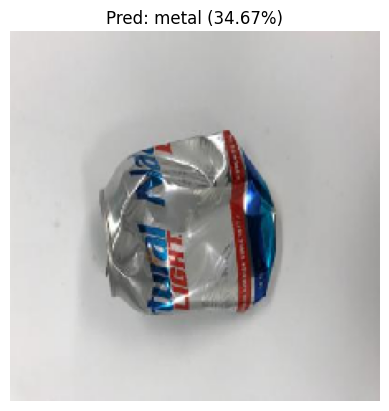

Predicted Index: 1
Predicted Label: metal
Confidence Score: 0.3467
------------------------------
All probabilities:
glass: 0.2721
metal: 0.3467
organic: 0.0626
paper: 0.0407
plastic: 0.2779


In [35]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/metal/metal103.jpg'

predict_image_multiclass(test_image_path, model)

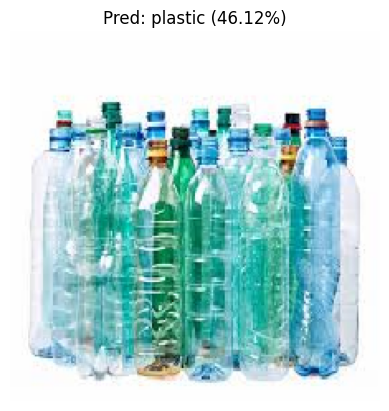

Predicted Index: 4
Predicted Label: plastic
Confidence Score: 0.4612
------------------------------
All probabilities:
glass: 0.4505
metal: 0.0660
organic: 0.0103
paper: 0.0120
plastic: 0.4612


In [36]:
test_image_path = '/content/drive/MyDrive/Testing-photos/download.jpg'

predict_image_multiclass(test_image_path, model)

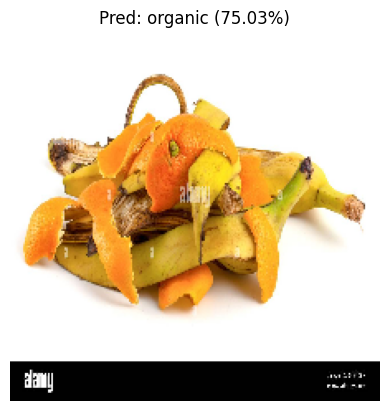

Predicted Index: 2
Predicted Label: organic
Confidence Score: 0.7503
------------------------------
All probabilities:
glass: 0.0339
metal: 0.0264
organic: 0.7503
paper: 0.1375
plastic: 0.0519


In [37]:
test_image_path = '/content/drive/MyDrive/Testing-photos/banana.jpg'

predict_image_multiclass(test_image_path, model)

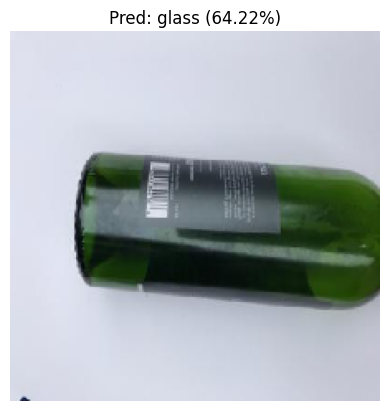

Predicted Index: 0
Predicted Label: glass
Confidence Score: 0.6422
------------------------------
All probabilities:
glass: 0.6422
metal: 0.0749
organic: 0.0004
paper: 0.0017
plastic: 0.2809


In [41]:
test_image_path = '/content/drive/MyDrive/Multiclassification_1/test/glass/glass277.jpg'

predict_image_multiclass(test_image_path, model)

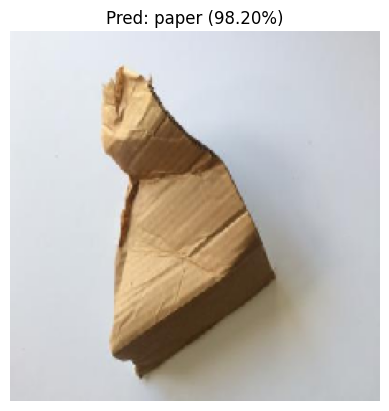

Predicted Index: 3
Predicted Label: paper
Confidence Score: 0.9820
------------------------------
All probabilities:
glass: 0.0055
metal: 0.0024
organic: 0.0017
paper: 0.9820
plastic: 0.0084


In [42]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/paper/cardboard145.jpg'

predict_image_multiclass(test_image_path, model)

# Apply Fine-tuning on VGG16

> Add blockquote



In [48]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# 1. Load VGG16
# include_top=False drops the original 1000-class layer
base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')

# 2. Freeze the entire base model
base_model.trainable = False

# 3. Build the Classifier Head
inputs = tf.keras.Input(shape=(224, 224, 3))

# OPTIONAL: If your data is 0-255 (no rescale), use this line to preprocess automatically:
# x = tf.keras.applications.vgg16.preprocess_input(inputs)

# If you already rescaled to 0-1 in your data generator, skip the line above and just do:
x = base_model(inputs, training=False)

x = layers.Flatten()(x) # VGG16 often works better with Flatten than GlobalAveragePooling
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x) # High dropout because VGG16 overfits easily
outputs = layers.Dense(5, activation='softmax')(x) # 5 Classes

model = models.Model(inputs, outputs)

# 4. Compile for Phase 1
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Run model.fit() here for ~10 epochs

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
# 1. Unfreeze the base model variables
base_model.trainable = True

# 2. Re-freeze earlier layers
# VGG16 has 5 blocks. We usually want to keep blocks 1-4 frozen
# and only retrain block 5.
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# 3. Compile with a VERY LOW learning rate
# If you use 0.001 here, you will destroy the pre-trained weights. Use 1e-5.
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Ready for Fine-Tuning (Block 5 only)")


Ready for Fine-Tuning (Block 5 only)


In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Define Callbacks to save the best model and stop if it stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)

# Optional: Save the model every time it gets better
checkpoint = ModelCheckpoint(
    'my_finetuned_vgg16.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 2. Run the training
# Adjust 'train_generator' and 'validation_generator' to match your variable names
fine_tune_epochs = 5  # We typically need fewer epochs for fine-tuning

history_fine = model.fit(
    training_data,
    epochs=fine_tune_epochs,
    validation_data=testing_data,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.2985 - loss: 1.7398
Epoch 1: val_loss improved from inf to 1.11354, saving model to my_finetuned_vgg16.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 850ms/step - accuracy: 0.2992 - loss: 1.7376 - val_accuracy: 0.5571 - val_loss: 1.1135
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.4928 - loss: 1.2378
Epoch 2: val_loss improved from 1.11354 to 0.90361, saving model to my_finetuned_vgg16.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 777ms/step - accuracy: 0.4933 - loss: 1.2369 - val_accuracy: 0.6497 - val_loss: 0.9036
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.6235 - loss: 0.9866
Epoch 3: val_loss improved from 0.90361 to 0.79343, saving model to my_finetuned_vgg16.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 785ms/step - accuracy: 0.6233 - loss: 0.9868 - val_accuracy: 0.6980 - val_loss: 0.7934
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.6630 - loss: 0.8999
Epoch 4: val_loss improved from

In [51]:
from google.colab import drive
import os

# Create a folder for your project (if it doesn't exist)
save_path = '/content/drive/MyDrive/Waste_classification'
if not os.path.exists(save_path):
    os.makedirs(save_path)

#  Save the FINAL model
# This saves the Architecture + Weights + Optimizer state
model.save(os.path.join(save_path, 'multiclass.keras'))

print(f"✅ Model successfully saved to: {save_path}")

✅ Model successfully saved to: /content/drive/MyDrive/Waste_classification


In [52]:
from tensorflow.keras.models import load_model
import os

# Define the path where the model was saved
save_path = '/content/drive/MyDrive/Waste_classification'
model_filename = 'multiclass.keras'
full_model_path = os.path.join(save_path, model_filename)

In [53]:
# Load the model
best = load_model(full_model_path)

In [54]:
probs = model.predict(testing_data,steps = len(testing_data), verbose = 1)
preds = np.argmax(probs,axis = 1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step


In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
# Use the true labels directly from the generator to match the predictions
true_labels_for_evaluation_ft = testing_data.classes

print(classification_report(true_labels_for_evaluation_ft,preds))
print(confusion_matrix(true_labels_for_evaluation_ft,preds))


              precision    recall  f1-score   support

           0       0.60      0.48      0.53       122
           1       0.69      0.77      0.73       147
           2       0.73      0.95      0.82       148
           3       0.88      0.88      0.88       236
           4       0.71      0.51      0.59       135

    accuracy                           0.75       788
   macro avg       0.72      0.72      0.71       788
weighted avg       0.74      0.75      0.74       788

[[ 58  30  12   4  18]
 [ 13 113   8  10   3]
 [  0   3 140   4   1]
 [  1   7  14 208   6]
 [ 25  11  19  11  69]]


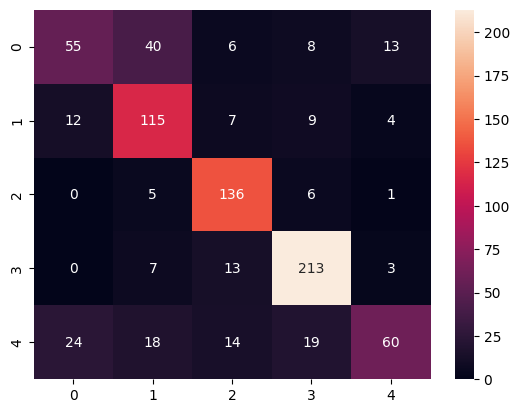

In [56]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.savefig('h1.png')

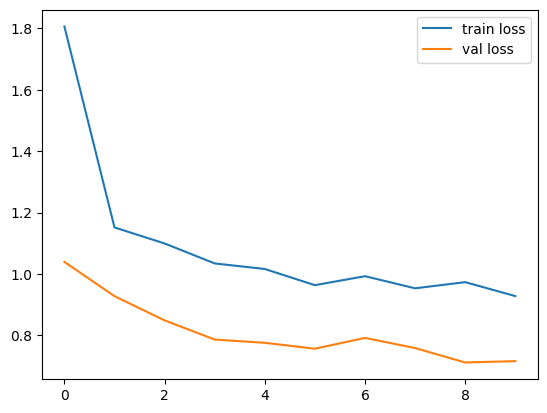

<Figure size 640x480 with 0 Axes>

In [57]:
plt.plot(result_VGG_TF.history['loss'], label='train loss')
plt.plot(result_VGG_TF.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

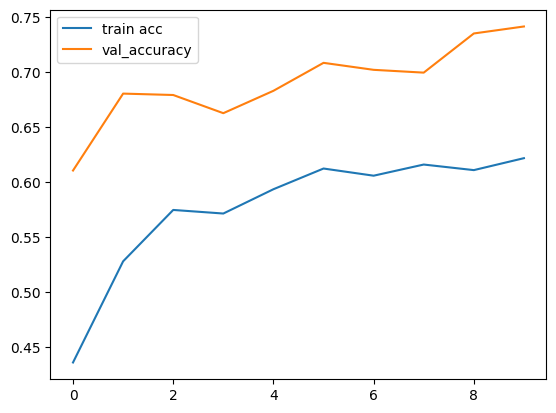

<Figure size 640x480 with 0 Axes>

In [58]:
# accuracies
plt.plot(result_VGG_TF.history['accuracy'], label='train acc')
plt.plot(result_VGG_TF.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

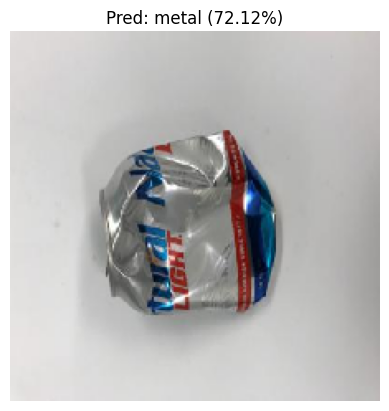

Predicted Index: 1
Predicted Label: metal
Confidence Score: 0.7212
------------------------------
All probabilities:
glass: 0.0842
metal: 0.7212
organic: 0.0093
paper: 0.0183
plastic: 0.1670


In [59]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/metal/metal103.jpg'

predict_image_multiclass(test_image_path, best)

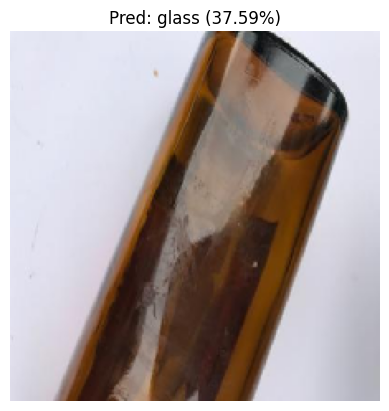

Predicted Index: 0
Predicted Label: glass
Confidence Score: 0.3759
------------------------------
All probabilities:
glass: 0.3759
metal: 0.2020
organic: 0.0251
paper: 0.3177
plastic: 0.0793


In [60]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/glass/glass142.jpg'

predict_image_multiclass(test_image_path, best)

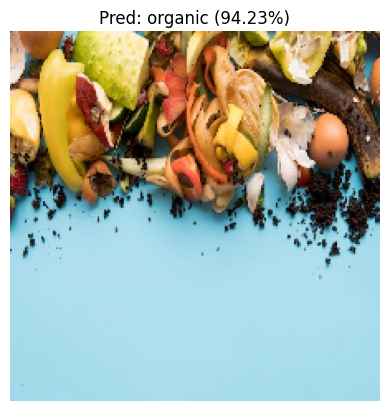

Predicted Index: 2
Predicted Label: organic
Confidence Score: 0.9423
------------------------------
All probabilities:
glass: 0.0082
metal: 0.0110
organic: 0.9423
paper: 0.0160
plastic: 0.0224


In [61]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/organic/top-view-trash-cooking-concept_23-2149056487.jpg'

predict_image_multiclass(test_image_path, best)

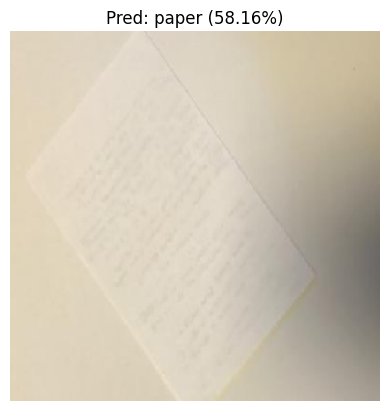

Predicted Index: 3
Predicted Label: paper
Confidence Score: 0.5816
------------------------------
All probabilities:
glass: 0.0944
metal: 0.0854
organic: 0.0356
paper: 0.5816
plastic: 0.2029


In [62]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/paper/paper539.jpg'

predict_image_multiclass(test_image_path, best)

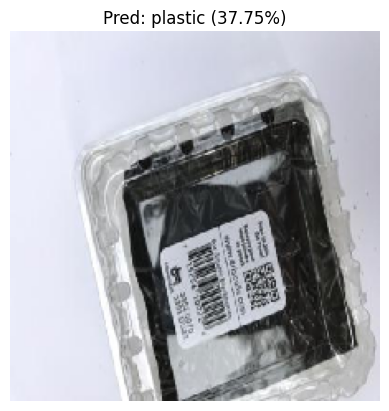

Predicted Index: 4
Predicted Label: plastic
Confidence Score: 0.3775
------------------------------
All probabilities:
glass: 0.2549
metal: 0.2171
organic: 0.0143
paper: 0.1362
plastic: 0.3775


In [63]:
test_image_path = '/content/drive/MyDrive/Multiclassification/test/plastic/plastic285.jpg'

predict_image_multiclass(test_image_path, best)